# Torch Batteries Example: Function Fitting with MLP

This notebook demonstrates how to use the `torch-batteries` library to train a Multi-Layer Perceptron (MLP) for function fitting. We'll use the event-driven training approach with the `@charge` decorator to define training, validation, testing, and prediction steps.

## Overview

We'll be fitting a polynomial function: `y = (x-1)(x-6)(x-7)` using a neural network with the Battery trainer class.

## 1. Setup and Dependencies

First, let's import the required libraries and check the versions of torch-batteries and PyTorch.

In [1]:
# Import torch-batteries and other dependencies
import torch

import torch_batteries

print(f"torch-batteries version: {torch_batteries.__version__}")
print(f"PyTorch version: {torch.__version__}")

torch-batteries version: 0.1.0
PyTorch version: 2.9.1


## 2. Data Preparation

We'll create a synthetic dataset by sampling from the polynomial function `y = (x-1)(x-6)(x-7)` and split it into training, validation, and test sets.

In [2]:
# Prepare data loaders
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

x = np.linspace(0, 10, 300).reshape(-1, 1).astype(np.float32)
y = ((x - 1)*(x - 6)*(x - 7)).astype(np.float32)

x_tensor = torch.from_numpy(x)
y_tensor = torch.from_numpy(y)

BATCH_SIZE = 16

pred_full_dataset = TensorDataset(x_tensor, y_tensor)
pred_full_loader = DataLoader(pred_full_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Split data into train/validation/test sets
x_train, x_rest, y_train, y_rest = train_test_split(
    x_tensor, y_tensor, test_size=0.3, random_state=42
)

x_val, x_test, y_val, y_test = train_test_split(
    x_rest, y_rest, test_size=0.5, random_state=42
)

# Create datasets and data loaders
train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)
test_dataset = TensorDataset(x_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Training samples: 210
Validation samples: 45
Test samples: 45
Batch size: 16
Training batches: 14
Validation batches: 3
Test batches: 3


## 3. Model Definition and Training

Now we'll define our MLP model using the `@charge` decorator to specify what happens during training, validation, testing, and prediction steps. This event-driven approach makes the code more organized and follows a clear pattern.

### Key Features:
- **@charge(Event.TRAIN_STEP)**: Defines the forward pass and loss calculation for training
- **@charge(Event.VALIDATION_STEP)**: Defines validation logic
- **@charge(Event.TEST_STEP)**: Defines testing logic
- **@charge(Event.PREDICT_STEP)**: Defines prediction logic (forward pass only)

In [3]:
# Import torch-batteries components
import torch.nn as nn
from torch.nn import functional as F
from torch_batteries import Battery, Event, charge

# Define MLP model with charge decorators
class MLPModel(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=64, output_dim=1):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, output_dim)
        )
    
    def forward(self, x):
        return self.network(x)
    
    @charge(Event.TRAIN_STEP)
    def training_step(self, batch):
        """Define what happens in each training step."""
        x, y = batch
        pred = self(x)
        loss = F.mse_loss(pred, y)
        return loss
    
    @charge(Event.VALIDATION_STEP)
    def validation_step(self, batch):
        """Define what happens in each validation step."""
        x, y = batch
        pred = self(x)
        loss = F.mse_loss(pred, y)
        
        return loss
    
    @charge(Event.TEST_STEP)
    def test_step(self, batch):
        """Define what happens in each test step."""
        x, y = batch
        pred = self(x)
        loss = F.mse_loss(pred, y)
        
        return loss

    @charge(Event.PREDICT_STEP)
    def prediction_step(self, batch):
        """Define what happens during prediction."""
        x = batch[0]
        pred = self(x)
        return pred

model = MLPModel(input_dim=1, hidden_dim=64, output_dim=1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

battery = Battery(model, optimizer=optimizer)

print("Starting training...")
train_results = battery.train(
    train_loader=train_loader, 
    val_loader=val_loader, 
    epochs=100
)

print("Training completed!")
print(f"Final Training Loss: {train_results['train_loss'][-1]:.6f}")
print(f"Final Validation Loss: {train_results['val_loss'][-1]:.6f}")

Starting training...
Epoch 1/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 884.9190
Validation: 3/3 ███████████████████████████████████████ 100%, val_loss: 637.7997


Epoch 2/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 751.4350
Validation: 3/3 ███████████████████████████████████████ 100%, val_loss: 528.4277


Epoch 3/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 571.1834
Validation: 3/3 ███████████████████████████████████████ 100%, val_loss: 432.2388


Epoch 4/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 460.0961
Validation: 3/3 ███████████████████████████████████████ 100%, val_loss: 456.7051


Epoch 5/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 447.7281
Validation: 3/3 ███████████████████████████████████████ 100%, val_loss: 430.5228


Epoch 6/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 441.4981
Validation: 3/3 ███████████████████████████████████████ 100%, val_loss: 430.9909


Epoch 7/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 442.7450
Validation: 3/3 ███████████████████████████████████████ 100%, val_loss: 431.5881


Epoch 8/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 454.7476
Validation: 3/3 ███████████████████████████████████████ 100%, val_loss: 463.9052


Epoch 9/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 441.4644
Validation: 3/3 ███████████████████████████████████████ 100%, val_loss: 419.6683


Epoch 10/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 436.4350
Validation: 3/3 ███████████████████████████████████████ 100%, val_loss: 412.4345


Epoch 11/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 429.0571
Validation: 3/3 ███████████████████████████████████████ 100%, val_loss: 414.8058


Epoch 12/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 424.7784
Validation: 3/3 ███████████████████████████████████████ 100%, val_loss: 414.9302


Epoch 13/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 416.9994
Validation: 3/3 ███████████████████████████████████████ 100%, val_loss: 386.4136


Epoch 14/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 416.2576
Validation: 3/3 ███████████████████████████████████████ 100%, val_loss: 377.8205


Epoch 15/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 402.9280
Validation: 3/3 ███████████████████████████████████████ 100%, val_loss: 362.4146


Epoch 16/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 391.9527
Validation: 3/3 ███████████████████████████████████████ 100%, val_loss: 342.4668


Epoch 17/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 378.0607
Validation: 3/3 ███████████████████████████████████████ 100%, val_loss: 325.4298


Epoch 18/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 379.3020
Validation: 3/3 ███████████████████████████████████████ 100%, val_loss: 323.8028


Epoch 19/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 373.3640
Validation: 3/3 ███████████████████████████████████████ 100%, val_loss: 322.6439


Epoch 20/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 365.5627
Validation: 3/3 ███████████████████████████████████████ 100%, val_loss: 311.7433


Epoch 21/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 363.4838
Validation: 3/3 ███████████████████████████████████████ 100%, val_loss: 315.3765


Epoch 22/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 369.8261
Validation: 3/3 ███████████████████████████████████████ 100%, val_loss: 316.2376


Epoch 23/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 346.3800
Validation: 3/3 ███████████████████████████████████████ 100%, val_loss: 294.3300


Epoch 24/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 353.0611
Validation: 3/3 ███████████████████████████████████████ 100%, val_loss: 305.6400


Epoch 25/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 331.9302
Validation: 3/3 ███████████████████████████████████████ 100%, val_loss: 301.4755


Epoch 26/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 364.3779
Validation: 3/3 ███████████████████████████████████████ 100%, val_loss: 277.3455


Epoch 27/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 318.6920
Validation: 3/3 ███████████████████████████████████████ 100%, val_loss: 280.6325


Epoch 28/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 311.0149
Validation: 3/3 ███████████████████████████████████████ 100%, val_loss: 299.6900


Epoch 29/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 376.6818
Validation: 3/3 ███████████████████████████████████████ 100%, val_loss: 258.1966


Epoch 30/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 284.7683
Validation: 3/3 ███████████████████████████████████████ 100%, val_loss: 249.6000


Epoch 31/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 349.5937
Validation: 3/3 ███████████████████████████████████████ 100%, val_loss: 344.1810


Epoch 32/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 298.0168
Validation: 3/3 ███████████████████████████████████████ 100%, val_loss: 222.0019


Epoch 33/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 263.6101
Validation: 3/3 ███████████████████████████████████████ 100%, val_loss: 211.8650


Epoch 34/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 254.4870
Validation: 3/3 ███████████████████████████████████████ 100%, val_loss: 215.7376


Epoch 35/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 230.4058
Validation: 3/3 ███████████████████████████████████████ 100%, val_loss: 189.8424


Epoch 36/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 209.9330
Validation: 3/3 ███████████████████████████████████████ 100%, val_loss: 175.9431


Epoch 37/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 190.1246
Validation: 3/3 ███████████████████████████████████████ 100%, val_loss: 220.3788


Epoch 38/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 208.9759
Validation: 3/3 ███████████████████████████████████████ 100%, val_loss: 145.5552


Epoch 39/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 164.7657
Validation: 3/3 ███████████████████████████████████████ 100%, val_loss: 148.9618


Epoch 40/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 161.4491
Validation: 3/3 ███████████████████████████████████████ 100%, val_loss: 121.4585


Epoch 41/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 176.5745
Validation: 3/3 ███████████████████████████████████████ 100%, val_loss: 111.0208


Epoch 42/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 134.7505
Validation: 3/3 ███████████████████████████████████████ 100%, val_loss: 112.8183


Epoch 43/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 126.0032
Validation: 3/3 ███████████████████████████████████████ 100%, val_loss: 122.4155


Epoch 44/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 107.0905
Validation: 3/3 ████████████████████████████████████████ 100%, val_loss: 88.7818


Epoch 45/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 99.5926
Validation: 3/3 ████████████████████████████████████████ 100%, val_loss: 78.1487


Epoch 46/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 111.9967
Validation: 3/3 ████████████████████████████████████████ 100%, val_loss: 74.2723


Epoch 47/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 81.7511
Validation: 3/3 ████████████████████████████████████████ 100%, val_loss: 69.0510


Epoch 48/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 71.5894
Validation: 3/3 ████████████████████████████████████████ 100%, val_loss: 93.3287


Epoch 49/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 85.7751
Validation: 3/3 ████████████████████████████████████████ 100%, val_loss: 57.9872


Epoch 50/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 62.4216
Validation: 3/3 ████████████████████████████████████████ 100%, val_loss: 57.1211


Epoch 51/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 58.8748
Validation: 3/3 ████████████████████████████████████████ 100%, val_loss: 52.6383


Epoch 52/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 75.0506
Validation: 3/3 ████████████████████████████████████████ 100%, val_loss: 45.2744


Epoch 53/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 61.3348
Validation: 3/3 ████████████████████████████████████████ 100%, val_loss: 43.8703


Epoch 54/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 61.9907
Validation: 3/3 ████████████████████████████████████████ 100%, val_loss: 44.5747


Epoch 55/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 49.6698
Validation: 3/3 ████████████████████████████████████████ 100%, val_loss: 38.1580


Epoch 56/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 44.1710
Validation: 3/3 ████████████████████████████████████████ 100%, val_loss: 52.1270


Epoch 57/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 84.6063
Validation: 3/3 ████████████████████████████████████████ 100%, val_loss: 35.3335


Epoch 58/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 66.4598
Validation: 3/3 ████████████████████████████████████████ 100%, val_loss: 33.9088


Epoch 59/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 45.4438
Validation: 3/3 ████████████████████████████████████████ 100%, val_loss: 31.1674


Epoch 60/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 34.5936
Validation: 3/3 ████████████████████████████████████████ 100%, val_loss: 29.2233


Epoch 61/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 36.1338
Validation: 3/3 ████████████████████████████████████████ 100%, val_loss: 27.3451


Epoch 62/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 32.3758
Validation: 3/3 ████████████████████████████████████████ 100%, val_loss: 25.0649


Epoch 63/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 34.5359
Validation: 3/3 ████████████████████████████████████████ 100%, val_loss: 39.9939


Epoch 64/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 43.4995
Validation: 3/3 ████████████████████████████████████████ 100%, val_loss: 33.8207


Epoch 65/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 32.0110
Validation: 3/3 ████████████████████████████████████████ 100%, val_loss: 35.5548


Epoch 66/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 29.2834
Validation: 3/3 ████████████████████████████████████████ 100%, val_loss: 22.2681


Epoch 67/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 23.3366
Validation: 3/3 ████████████████████████████████████████ 100%, val_loss: 21.1444


Epoch 68/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 25.8360
Validation: 3/3 ████████████████████████████████████████ 100%, val_loss: 18.3184


Epoch 69/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 24.2824
Validation: 3/3 ████████████████████████████████████████ 100%, val_loss: 37.0388


Epoch 70/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 26.1879
Validation: 3/3 ████████████████████████████████████████ 100%, val_loss: 35.7985


Epoch 71/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 26.2673
Validation: 3/3 ████████████████████████████████████████ 100%, val_loss: 18.5657


Epoch 72/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 20.2984
Validation: 3/3 ████████████████████████████████████████ 100%, val_loss: 16.8403


Epoch 73/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 28.0089
Validation: 3/3 ████████████████████████████████████████ 100%, val_loss: 15.9784


Epoch 74/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 17.7022
Validation: 3/3 ████████████████████████████████████████ 100%, val_loss: 20.8498


Epoch 75/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 24.2956
Validation: 3/3 ████████████████████████████████████████ 100%, val_loss: 16.7270


Epoch 76/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 18.8318
Validation: 3/3 ████████████████████████████████████████ 100%, val_loss: 15.4843


Epoch 77/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 17.4666
Validation: 3/3 ████████████████████████████████████████ 100%, val_loss: 12.8388


Epoch 78/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 13.8205
Validation: 3/3 ████████████████████████████████████████ 100%, val_loss: 22.1593


Epoch 79/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 24.0575
Validation: 3/3 ████████████████████████████████████████ 100%, val_loss: 15.3980


Epoch 80/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 19.1501
Validation: 3/3 ████████████████████████████████████████ 100%, val_loss: 25.6106


Epoch 81/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 19.9963
Validation: 3/3 ████████████████████████████████████████ 100%, val_loss: 43.5131


Epoch 82/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 24.6113
Validation: 3/3 ████████████████████████████████████████ 100%, val_loss: 25.3995


Epoch 83/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 22.9570
Validation: 3/3 ████████████████████████████████████████ 100%, val_loss: 10.1013


Epoch 84/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 15.3969
Validation: 3/3 ████████████████████████████████████████ 100%, val_loss: 20.0056


Epoch 85/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 22.4307
Validation: 3/3 █████████████████████████████████████████ 100%, val_loss: 9.5541


Epoch 86/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 12.0324
Validation: 3/3 ████████████████████████████████████████ 100%, val_loss: 11.5783


Epoch 87/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 12.3021
Validation: 3/3 █████████████████████████████████████████ 100%, val_loss: 8.1621


Epoch 88/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 12.1442
Validation: 3/3 ████████████████████████████████████████ 100%, val_loss: 17.7200


Epoch 89/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 21.9188
Validation: 3/3 █████████████████████████████████████████ 100%, val_loss: 7.4856


Epoch 90/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 16.8046
Validation: 3/3 ████████████████████████████████████████ 100%, val_loss: 26.4559


Epoch 91/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 15.1262
Validation: 3/3 █████████████████████████████████████████ 100%, val_loss: 7.8779


Epoch 92/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 12.5846
Validation: 3/3 ████████████████████████████████████████ 100%, val_loss: 11.7047


Epoch 93/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 10.5486
Validation: 3/3 █████████████████████████████████████████ 100%, val_loss: 9.6503


Epoch 94/100


Train: 14/14 ████████████████████████████████████████████████ 100%, loss: 9.6743
Validation: 3/3 ████████████████████████████████████████ 100%, val_loss: 15.1626


Epoch 95/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 11.8462
Validation: 3/3 ████████████████████████████████████████ 100%, val_loss: 43.2779


Epoch 96/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 70.0090
Validation: 3/3 █████████████████████████████████████████ 100%, val_loss: 8.2538


Epoch 97/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 41.2970
Validation: 3/3 ████████████████████████████████████████ 100%, val_loss: 16.0013


Epoch 98/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 18.8681
Validation: 3/3 █████████████████████████████████████████ 100%, val_loss: 8.6070


Epoch 99/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 17.2784
Validation: 3/3 █████████████████████████████████████████ 100%, val_loss: 8.1973


Epoch 100/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 15.8442
Validation: 3/3 ████████████████████████████████████████ 100%, val_loss: 16.5502

Training completed!
Final Training Loss: 15.844151
Final Validation Loss: 16.550162


## 4. Model Evaluation

Let's evaluate our trained model on the test set to see how well it generalizes to unseen data.

In [4]:
test_results = battery.test(test_loader)
print(f"Final Test Loss: {test_results['test_loss']:.6f}")

Test: 3/3 ██████████████████████████████████████████████████ 100%, loss: 20.7054

Final Test Loss: 20.705402


## 5. Results Visualization

Finally, let's visualize the training progress and see how well our model learned to approximate the target function.

Predict: 19/19 ████████████████████████████████████████████████████████████ 100%


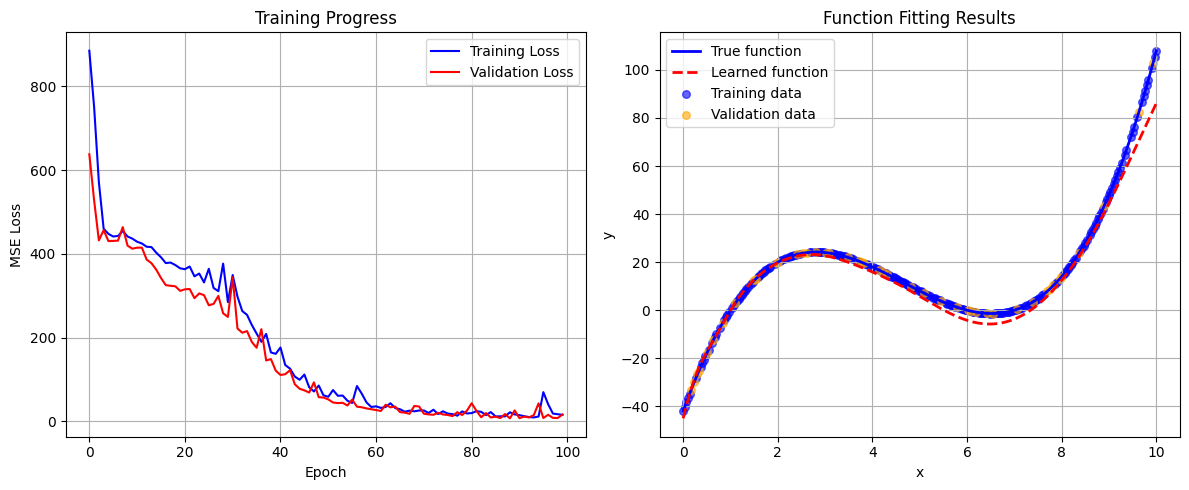

In [5]:
import matplotlib.pyplot as plt

# Plot training progress
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_results['train_loss'], 'b-', label='Training Loss')
plt.plot(train_results['val_loss'], 'r-', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Progress')
plt.legend()
plt.grid(True)

predictions = battery.predict(pred_full_loader)['predictions']

# Concatenate predictions
y_pred = torch.cat(predictions, dim=0).cpu().numpy()
x_np = x_tensor.cpu().numpy()

# Plot actual vs predicted function
plt.subplot(1, 2, 2)
plt.plot(x_np, y, 'b-', label='True function', linewidth=2)
plt.plot(x_np, y_pred, 'r--', label='Learned function', linewidth=2)
plt.scatter(x_train.numpy(), y_train.numpy(), alpha=0.6, s=30, c='blue', label='Training data')
plt.scatter(x_val.numpy(), y_val.numpy(), alpha=0.6, s=30, c='orange', label='Validation data')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Function Fitting Results')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()